# **CNN**

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [20]:
transform = transforms.Compose(
[transforms.ToTensor(),
transforms.Normalize((0.5), (0.5))])

In [21]:
batch_size = 4
trainset = torchvision.datasets.MNIST(root='./data', train=True,download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=2)
testset = torchvision.datasets.MNIST(root='./data', train=False,download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)
classes = ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine')

In [22]:
import matplotlib.pyplot as plt
import numpy as np

In [26]:
def imshow(img):
  img = img / 2 + 0.5 # unnormalize
  np.img = img.numpy()
  plt.imshow(np.transpose(np.img, (1, 2, 0)))
  plt.show()

In [27]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

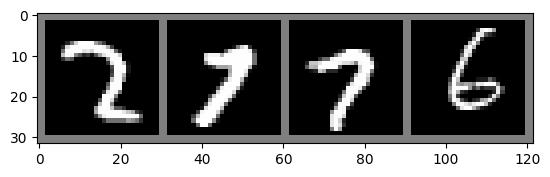

2 - two 7 - seven 7 - seven 6 - six


In [28]:
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


In [29]:
import torch.nn as nn
import torch.nn.functional as F

In [48]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # Corrected input size
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [49]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [50]:
for epoch in range(2): # loop over the dataset multiple times
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    # print statistics
    running_loss += loss.item()
    if i % 2000 == 1999: # print every 2000 mini-batches
      print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
      running_loss = 0.0
print('Finished Training')


[1,  2000] loss: 1.097
[1,  4000] loss: 0.216
[1,  6000] loss: 0.148
[1,  8000] loss: 0.118
[1, 10000] loss: 0.101
[1, 12000] loss: 0.086
[1, 14000] loss: 0.077
[2,  2000] loss: 0.063
[2,  4000] loss: 0.058
[2,  6000] loss: 0.071
[2,  8000] loss: 0.054
[2, 10000] loss: 0.058
[2, 12000] loss: 0.061
[2, 14000] loss: 0.051
Finished Training


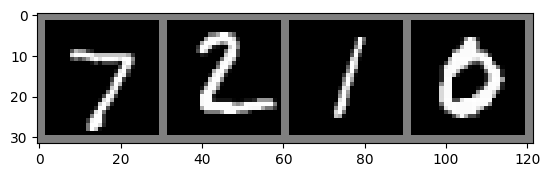

GroundTruth:  7 - seven 2 - two 1 - one 0 - zero


In [52]:
dataiter = iter(testloader)
images, labels = next(dataiter)
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [53]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  7 - seven 2 - two 1 - one 0 - zero


In [54]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our
outputs
with torch.no_grad():
  for data in testloader:
    images, labels = data
    # calculate outputs by running images through the network
    outputs = net(images)
    # the class with the highest energy is what we choose as prediction
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total}%')

Accuracy of the network on the 10000 test images: 98%


In [55]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

In [56]:
# again no gradients needed
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predictions = torch.max(outputs, 1)
    # collect the correct predictions for each class
    for label, prediction in zip(labels, predictions):
      if label == prediction:
        correct_pred[classes[label]] += 1
      total_pred[classes[label]] += 1

In [57]:
# print accuracy for each class
for classname, correct_count in correct_pred.items():
  accuracy = 100 * float(correct_count) / total_pred[classname]
print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: 9 - nine is 97.1 %


# **R-CNN**

In [58]:
import torchvision.transforms.functional as F
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

In [76]:
def get_faster_rcnn_model(num_classes):
    backbone = torchvision.models.resnet50(pretrained=True)
    backbone.out_channels = 2048  # Specify the number of output channels
    num_classes = num_classes  # including background
    anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                       aspect_ratios=((0.5, 1.0, 2.0),))
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                     output_size=7,
                                                     sampling_ratio=2)
    model = FasterRCNN(backbone,
                       num_classes=num_classes,
                       rpn_anchor_generator=anchor_generator,
                       box_roi_pool=roi_pooler)
    return model

# Initialize the model
num_classes = 11  # 10 digits + background
model = get_faster_rcnn_model(num_classes)

# Define the optimizer and loss function
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# model.to(device)

# Train the model
num_epochs = 2
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()

for epoch in range(num_epochs):
    model.train()
    for images, labels in trainloader:
        images = [image.to(device) for image in images]
        targets = [{"boxes": torch.Tensor([[0, 0, 1, 1]])} for _ in images]
        images = torch.stack(images)

        # Clear gradients
        optimizer.zero_grad()

        # Forward pass (inside autocast to use mixed precision)
        with autocast():
            losses = model(images, targets)

        # Backward pass
        scaler.scale(losses).backward()
        scaler.step(optimizer)
        scaler.update()

        lr_scheduler.step()  # Step LR scheduler

        # Free up GPU memory
        torch.cuda.empty_cache()



# # Save the trained model
# torch.save(model.state_dict(), 'faster_rcnn_mnist.pth')

print("Training finished.")

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 3.06 MiB is free. Process 13757 has 14.74 GiB memory in use. Of the allocated memory 14.50 GiB is allocated by PyTorch, and 113.63 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)